# Galaxy sampling checks

## Imports

In [59]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.stats import norm
from scipy.integrate import quad

import sys
sys.path.append('..')
from src.sfh import GSMF, SFMR, MZR, Corrections
from src.sampling import GalaxyGrid
from src.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from src.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

## Definitions

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [4]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [5]:
logm_min = 6
logm_max = 12

In [6]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [7]:
MZR_option = midmet_MZR
SFMR_option = midmet_SFMR
GSMF_option = midmet_GSMF_fixedslope
file_suffix = '_midmet'

In [8]:
def madau2014_sfrd(z):
    z_ = 1+z
    return 0.015 * z_**2.7 / (1 + (z_/2.9)**5.6)

In [9]:
def sfrd(redshift, flattening, fixed_slope, scatter_model):
    sfmr = SFMR(redshift=redshift,
                flattening=flatenning,
                scatter_model=scatter_model)
    gsmf = GSMF(redshift=redshift,
                fixed_slope=fixed_slope)
    def f(logm): 
        return 10.**sfmr.logsfr(logm) * 10.**gsmf.log_gsmf(logm)
    sfrd = quad(f, 6., 12.)[0]
    return sfrd

In [10]:
def sfrd_dlogm(redshift, logm, flattening, fixed_slope, scatter_model):
    sfmr = SFMR(redshift=redshift,
                flattening=flattening,
                scatter_model=scatter_model)
    gsmf = GSMF(redshift=redshift,
                fixed_slope=fixed_slope)
    return 10.**sfmr.logsfr(logm) * 10.**gsmf.log_gsmf(logm)

# Consistency checks

## Redshift sampling

In [11]:
n_redshift = 10
redshift_min = 0
redshift_max = 10
force_boundary_redshift = True
logm_min = 6
logm_max = 12
logm_per_redshift = 100
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'sfr' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [12]:
bg_galaxygrid = GalaxyGrid(n_redshift,
                        redshift_min,
                        redshift_max,
                        force_boundary_redshift,
                        logm_per_redshift,
                        logm_min, 
                        logm_max, 
                        mzr_model, 
                        sfmr_flattening,
                        gsmf_slope_fixed,
                        sampling_mode,
                        scatter_model,
                        apply_igimf_corrections,
                        random_state)

In [13]:
%%time
bg_galaxygrid.sample_redshift()

CPU times: user 1min 59s, sys: 5.5 ms, total: 1min 59s
Wall time: 1min 59s


`sample_redshift` first finds the `n_redshift+1` (`n_redshift+3` if `force_boundary_redshift==True`) quantiles. These are the limits of the `n_redshift` (`n_redshift+2`) bins between `redshift_min` and `redshift_max` such that falling into any one of them is equally likely (according to the `sampling_mode` option). Then, each bin is assigned a representative redshift that joins the final sample. This representative redshift is an average weighted by either mass density, number density or SFRD, depending on `sampling_mode`. If `force_boundary_redshift==True`, then the first and last redshifts are an exception, as they are explicitly set to `redshift_min` and `redshift_max` regardless of `sampling_mode`.

In [14]:
bg_galaxygrid.sample_redshift_bins, bg_galaxygrid.sample_redshift_array

(array([ 0.        ,  0.31612969,  1.005     ,  1.445     ,  1.775     ,
         2.085     ,  2.445     ,  2.875     ,  3.405     ,  4.115     ,
         5.325     ,  8.18917494, 10.        ]),
 array([ 0.        ,  0.63225939,  1.23882325,  1.61509048,  1.92769193,
         2.26012893,  2.65249188,  3.13018647,  3.7395647 ,  4.64440759,
         6.37834989, 10.        ]))

Let's look at the sample relative to the probability distribution, which in this case is the SFRD over redshift.

In [116]:
model_settings = {
    'flattening': SFMR_option,
    'fixed_slope': GSMF_option,
    'scatter_model': 'none',
    'igimf' : True
}

In [19]:
# Our implementation: compute the SFRD analytically, no accounting for scatter

plot_redshifts = np.linspace(redshift_min, redshift_max, 100)
plot_sfrds = np.zeros(plot_redshifts.shape)


for i, redshift in enumerate(plot_redshifts):
    plot_sfrds[i] = sfrd(redshift, **model_settings)

plot_sfrds_thiswork = plot_sfrds

In [20]:
# Chruslinska et al. (2019, 2020) implementation: MC sampling with scatter

# Define redshift & galaxy stellar mass bins
redshift_bins = np.linspace(0, 10, 31)
redshift_centers = np.array([(z0+z1)/2 for z0, z1 in zip(redshift_bins[:-1], redshift_bins[1:])])
mass_bins = np.logspace(6, 12, 11)  # mass bins within each redshift bin
n_masses_per_bin = 100  # how many masses to sample within each mass bin

flattening = SFMR_option
fixed_slope = GSMF_option
scatter_model = 'normal'

plot_sfrds = np.zeros((redshift_bins.shape[0]-1,))
for i, (z0, z1) in enumerate(zip(redshift_bins[:-1], redshift_bins[1:])):
    # All quantities are assumed constant within each redshift bin.
    # We fix them to the midpoint redshift.
    fixed_z = (z0+z1)/2  
    gsmf = GSMF(redshift=fixed_z,
                fixed_slope=fixed_slope)

    # Number density of galaxies of log stellar mass logm, at redshift fixed_z,
    # per logarithmic mass bin.
    def d_ndensity(logm):
        return 10.**gsmf.log_gsmf(logm)
        
    redshift_sfrds = np.zeros((mass_bins.shape[0]-1,))
    for j, (m0, m1) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
        # Get the total number density within the bin.
        ndensity = quad(d_ndensity, np.log10(m0), np.log10(m1))[0]
        # Each galaxies represents a fraction of this density.
        ndensities = np.tile(ndensity / n_masses_per_bin, n_masses_per_bin)
        
        # Randomly draw masses within the bin. Weights are uniform
        # because we assume constant density.
        masses = np.random.choice(np.linspace(m0, m1, 100*n_masses_per_bin),
                                  p=np.ones(100*n_masses_per_bin)/(100*n_masses_per_bin),
                                  size=n_masses_per_bin)

        # Now get the SFR at the drawn masses.
        sfmr = SFMR(redshift=(z0+z1)/2,
                    flattening=flattening,
                    scatter_model=scatter_model)
        sfrs = np.array([10.**sfmr.logsfr(np.log10(m)) for m in masses])

        # Now the SFRD. Because ndensities accounts for the physical number density,
        # in this way we can arrive at the physical SFRD for any sample size.
        mass_sfrds = sfrs * ndensities
        redshift_sfrds[j] = mass_sfrds.sum()

    # The total SFRD in each redshift bin is the sum of the contribution from all
    # mass bins
    sfrd_ = redshift_sfrds.sum()
    plot_sfrds[i] = sfrd_
plot_sfrds_chruslinska = plot_sfrds

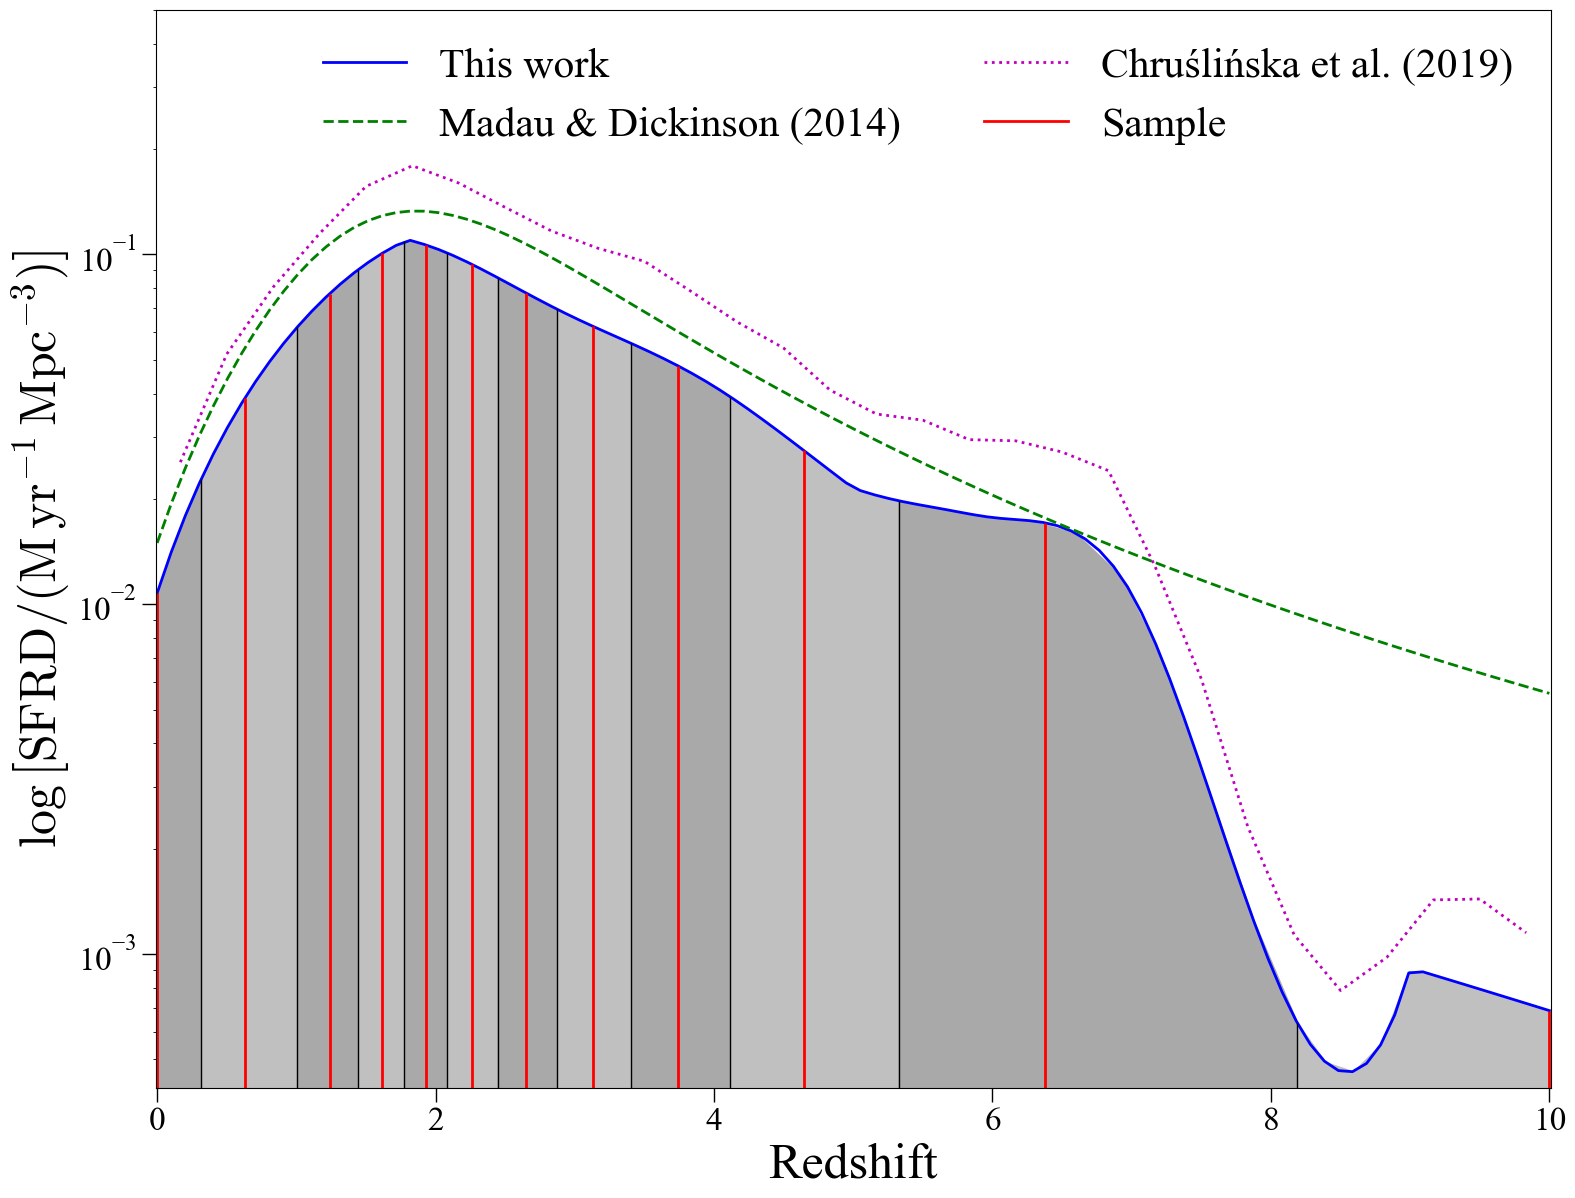

In [23]:
grid = bg_galaxygrid

fig, ax = plt.subplots(figsize=(18,14))

# Ref plots
ax.plot(plot_redshifts, plot_sfrds_thiswork, 'b-', label='This work')
ax.plot(plot_redshifts, madau2014_sfrd(plot_redshifts), 'g--', label='Madau & Dickinson (2014)')
ax.plot(redshift_centers, plot_sfrds_chruslinska, 'm:', label='Chruślińska et al. (2019)') 
min_sfrd = min(plot_sfrds_thiswork)*0.9


# SAMPLE
# Quantile bins
for i, (z0, z1) in enumerate(zip(grid.sample_redshift_bins[:-1], grid.sample_redshift_bins[1:])):
    c = 'darkgray'
    if i%2:
        c = 'silver'
    zs_ = np.linspace(z0, z1, 10)
    sfrds_ = [sfrd(z, **model_settings) for z in zs_]
    ax.fill_between(zs_, min_sfrd, sfrds_, color=c)
    ax.vlines(z0, min_sfrd, sfrd(z0, **model_settings), 'k', lw=1)

# Redshift sample
for z in grid.sample_redshift_array:
    ax.vlines(z, min_sfrd, sfrd(z, **model_settings), 'r', lw=2)

# Plot settings & decor
ax.set_yscale('log')
ax.set_ylim(min_sfrd, 0.5)
ax.set_xlim(redshift_min-0.01, redshift_max+0.01)

ax.set_ylabel(r'$\log\left[\mathrm{SFRD}/(\mathrm{M}\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')
ax.set_xlabel('Redshift')

# Legend
handles, labels = ax.get_legend_handles_labels()
sample_handle = Line2D([-2,-1], [1,1], color='r', linestyle='-', lw=2, label='Sample')
handles.append(sample_handle)
ax.legend(handles=handles, frameon=False, ncols=2, loc='upper right')

## Mass sampling

In [24]:
n_redshift = 3
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_min = 6
logm_max = 12
logm_per_redshift = 10
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'sfr' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [26]:
bg_galaxygrid = GalaxyGrid(n_redshift,
                        redshift_min,
                        redshift_max,
                        force_boundary_redshift,
                        logm_per_redshift,
                        logm_min, 
                        logm_max, 
                        mzr_model, 
                        sfmr_flattening,
                        gsmf_slope_fixed,
                        sampling_mode,
                        scatter_model,
                        apply_igimf_corrections,
                        random_state)

Here it is more convenient to manually set the sample redshifts.

In [30]:
bg_galaxygrid.sample_redshift_array = np.array([0.5, 2.5, 5])

In [31]:
%%time
bg_galaxygrid.get_grid()

CPU times: user 1.15 s, sys: 0 ns, total: 1.15 s
Wall time: 1.15 s


In [32]:
bg_galaxygrid.sample_logm_array, bg_galaxygrid.sample_logm_bins

(array([[ 7.58039704,  8.73118995,  9.21645605,  9.53720962,  9.78167782,
          9.9968551 , 10.202995  , 10.41150161, 10.63852837, 10.97870539],
        [ 7.4888883 ,  8.6681702 ,  9.22624026,  9.60347169,  9.89719505,
         10.15081946, 10.3836188 , 10.60992456, 10.85133582, 11.20186819],
        [ 7.26934726,  8.36490847,  8.8958321 ,  9.25608835,  9.52919641,
          9.74906499,  9.95665254, 10.200582  , 10.50933052, 11.03292803]]),
 array([[ 6.   ,  8.373,  9.015,  9.393,  9.669,  9.891, 10.101, 10.305,
         10.521, 10.767, 12.   ],
        [ 6.   ,  8.271,  8.991,  9.435,  9.759, 10.029, 10.269, 10.497,
         10.725, 10.989, 12.   ],
        [ 6.   ,  7.989,  8.673,  9.093,  9.405,  9.645,  9.849, 10.071,
         10.341, 10.701, 12.   ]]))

In [36]:
plot_redshifts = bg_galaxygrid.sample_redshift_array
plot_logms = np.linspace(6, 12, 100)

model_sfrds = np.zeros((plot_redshifts.shape[0], plot_logms.shape[0]))
for i, redshift in enumerate(plot_redshifts):
    model_sfrds[i] = np.array([sfrd_dlogm(redshift, logm, **model_settings) for logm in plot_logms])
min_sfrd = model_sfrds.min()

Text(0, 0.5, '$\\log\\left[\\mathrm{d}m/\\mathrm{d}t\\mathrm{d}V_c\\mathrm{d}\\log M_\\ast / (\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}\\,\\mathrm{Mpc}^{-3})\\right]$')

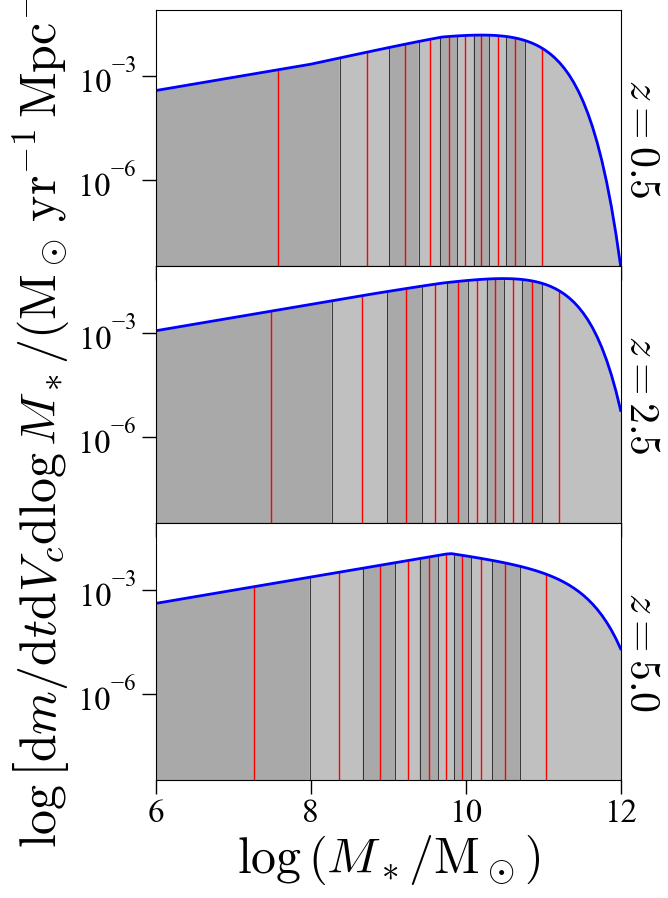

In [37]:
grid = bg_galaxygrid

fig, axes = plt.subplots(3, 1, figsize=(6,10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0)
axes = axes.flatten()

flatenning = SFMR_option
fixed_slope = GSMF_option
scatter_model = 'none'
for i_redshift, (ax, redshift) in enumerate(zip(axes, plot_redshifts)):    
    logm_arr = grid.sample_logm_array[i_redshift]
    logm_bin_arr = grid.sample_logm_bins[i_redshift]

    for i, (logm0, logm1) in enumerate(zip(logm_bin_arr[:-1], logm_bin_arr[1:])):
        c = 'darkgrey'
        if i%2:
            c = 'silver'
        logms_ = np.linspace(logm0, logm1, 10)
        sfrds_ = [sfrd_dlogm(redshift, logm, **model_settings) for logm in logms_]
        ax.fill_between(logms_, min_sfrd, sfrds_, color=c) 
        ax.vlines(logm0, min_sfrd, sfrd_dlogm(redshift, logm0, **model_settings), color='k', lw=0.5)

    for logm in logm_arr:
        ax.vlines(logm, min_sfrd, sfrd_dlogm(redshift, logm, **model_settings), color='r', lw=1)

    ax.plot(plot_logms, model_sfrds[i_redshift], 'b-')
    
    ax.text(1, 0.5, f'$z={redshift:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)

axes[0].set_yscale('log')
axes[0].set_ylim(min_sfrd)
axes[0].set_xlim(logm_min, logm_max)
axes[-1].set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$')
axes[1].set_ylabel(r'$\log\left[\mathrm{d}m/\mathrm{d}t\mathrm{d}V_c\mathrm{d}\log M_\ast / (\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

## Metallicity-SFR plane

### Background plot

In [213]:
model_settings = {
    'flattening': SFMR_option,
    'fixed_slope': GSMF_option,
    'mzr_model': MZR_option,
    'scatter_model': 'none',
    'igimf': True
}

First generate the redshift-logmass grid.

In [216]:
get_sample(np.linspace(6, 12, 10), 2, **model_settings)

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
 array([6.49669637, 6.88367065, 7.26822229, 7.64697917, 8.0123068 ,
        8.34864785, 8.6308587 , 8.83426653, 8.95580683, 9.01726903]))

In [267]:
logm = np.linspace(6, 12, 10)
redshift = 2
flattening = SFMR_option
scatter_model = 'none'
igimf = False


sfmr = SFMR(redshift=redshift,
            flattening=flattening,
            scatter_model=scatter_model)
mzr = MZR(redshift=redshift,
          model=MZR_option,
          scatter_model=scatter_model)
mzr.set_params()

logsfr = sfmr.logsfr(logm)
sfr = 10.**logsfr
zoh = mzr.zoh(logm)
feh = np.array([ZOH_to_FeH(x) for x in zoh])

if igimf:
    corrections = Corrections(feh, np.tile(logsfr.reshape((logsfr.shape[0], 1)), (1,feh.shape[0])))
    corrections.load_data()
    try:
        corr = np.diag(corrections.get_corrections())
    except ValueError:
        corr = np.tile(np.nan, sfr.shape[0])
    sfr *= 10.**corr

zoh, sfr

(array([6.49669637, 6.88367065, 7.26822229, 7.64697917, 8.0123068 ,
        8.34864785, 8.6308587 , 8.83426653, 8.95580683, 9.01726903]),
 array([1.15346843e-02, 4.12419360e-02, 1.47459371e-01, 5.27236795e-01,
        1.88512019e+00, 6.74019370e+00, 2.28589770e+01, 7.26762520e+01,
        2.31061854e+02, 7.34622094e+02]))

In [261]:
sfr.reshape((sfr.shape[0], 1))

array([[1.15346843e-02],
       [4.12419360e-02],
       [1.47459371e-01],
       [5.27236795e-01],
       [1.88512019e+00],
       [6.74019370e+00],
       [2.28589770e+01],
       [7.26762520e+01],
       [2.31061854e+02],
       [7.34622094e+02]])

In [262]:
np.tile(sfr.reshape((sfr.shape[0], 1)), (1,feh.shape[0]))

array([[1.15346843e-02, 1.15346843e-02, 1.15346843e-02, 1.15346843e-02,
        1.15346843e-02, 1.15346843e-02, 1.15346843e-02, 1.15346843e-02,
        1.15346843e-02, 1.15346843e-02],
       [4.12419360e-02, 4.12419360e-02, 4.12419360e-02, 4.12419360e-02,
        4.12419360e-02, 4.12419360e-02, 4.12419360e-02, 4.12419360e-02,
        4.12419360e-02, 4.12419360e-02],
       [1.47459371e-01, 1.47459371e-01, 1.47459371e-01, 1.47459371e-01,
        1.47459371e-01, 1.47459371e-01, 1.47459371e-01, 1.47459371e-01,
        1.47459371e-01, 1.47459371e-01],
       [5.27236795e-01, 5.27236795e-01, 5.27236795e-01, 5.27236795e-01,
        5.27236795e-01, 5.27236795e-01, 5.27236795e-01, 5.27236795e-01,
        5.27236795e-01, 5.27236795e-01],
       [1.88512019e+00, 1.88512019e+00, 1.88512019e+00, 1.88512019e+00,
        1.88512019e+00, 1.88512019e+00, 1.88512019e+00, 1.88512019e+00,
        1.88512019e+00, 1.88512019e+00],
       [6.74019370e+00, 6.74019370e+00, 6.74019370e+00, 6.74019370e+00,
   

In [263]:
corrections = Corrections(feh, np.log10(np.tile(sfr.reshape((sfr.shape[0], 1)), (1,feh.shape[0]))))
corrections.load_data()

In [265]:
np.log10(np.tile(sfr.reshape((sfr.shape[0], 1)), (1,feh.shape[0])))

array([[-1.93799429, -1.93799429, -1.93799429, -1.93799429, -1.93799429,
        -1.93799429, -1.93799429, -1.93799429, -1.93799429, -1.93799429],
       [-1.38466096, -1.38466096, -1.38466096, -1.38466096, -1.38466096,
        -1.38466096, -1.38466096, -1.38466096, -1.38466096, -1.38466096],
       [-0.83132762, -0.83132762, -0.83132762, -0.83132762, -0.83132762,
        -0.83132762, -0.83132762, -0.83132762, -0.83132762, -0.83132762],
       [-0.27799429, -0.27799429, -0.27799429, -0.27799429, -0.27799429,
        -0.27799429, -0.27799429, -0.27799429, -0.27799429, -0.27799429],
       [ 0.27533904,  0.27533904,  0.27533904,  0.27533904,  0.27533904,
         0.27533904,  0.27533904,  0.27533904,  0.27533904,  0.27533904],
       [ 0.82867238,  0.82867238,  0.82867238,  0.82867238,  0.82867238,
         0.82867238,  0.82867238,  0.82867238,  0.82867238,  0.82867238],
       [ 1.35905679,  1.35905679,  1.35905679,  1.35905679,  1.35905679,
         1.35905679,  1.35905679,  1.35905679

In [266]:
corrections.get_corrections()

array([[ 0.41116063,  0.41116063,  0.41116063,  0.41116063,  0.41116063,
         0.41116063,  0.41116063,  0.41116063,  0.41116063,  0.41116063],
       [ 0.25945047,  0.25945047,  0.25945047,  0.25945047,  0.25945047,
         0.25945047,  0.25945047,  0.25945047,  0.25945047,  0.25945047],
       [ 0.12115468,  0.12115468,  0.12115468,  0.12115468,  0.12115468,
         0.12115468,  0.12115468,  0.12115468,  0.12115468,  0.12115468],
       [-0.01710934, -0.01710934, -0.01710934, -0.01710934, -0.01710934,
        -0.01710934, -0.01710934, -0.01710934, -0.01710934, -0.01710934],
       [-0.15441572, -0.15441572, -0.15441572, -0.15441572, -0.15441572,
        -0.15441572, -0.15441572, -0.15441572, -0.15441572, -0.15441572],
       [-0.29032711, -0.29032711, -0.29032711, -0.29032711, -0.29032711,
        -0.29032711, -0.29032711, -0.29032711, -0.29032711, -0.29032711],
       [-0.40403772, -0.40403772, -0.40403772, -0.40403772, -0.40403772,
        -0.40403772, -0.40403772, -0.40403772

In [254]:
np.log10(np.tile(sfr.reshape((sfr.shape[0], 1)), (1,feh.shape[0]))).shape

(10, 10)

In [252]:
corrections = Corrections(np.array([-2, -1]), np.array([[2, 2], [3, 3]]))
corrections.load_data()

In [253]:
corrections.get_corrections()

array([[-0.57442065, -0.57442065],
       [-0.72991052, -0.72991052]])

In [209]:
def get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    sfmr = SFMR(redshift=redshift,
                flattening=flattening,
                scatter_model=scatter_model)
    mzr = MZR(redshift=redshift,
              model=mzr_model,
              scatter_model=scatter_model)
    mzr.set_params()

    sfr = 10.**sfmr.logsfr(logm)
    zoh = mzr.zoh(logm)
    feh = np.array([ZOH_to_FeH(x) for x in zoh])

    if igimf:
        corrections = Corrections(feh, np.tile(sfr.reshape(1, sfr.shape[0]), (feh.shape[0], 1)))
        corrections.load_data()
        try:
            corr = np.diag(corrections.get_corrections())
        except ValueError:
            corr = np.tile(np.nan, sfr.shape[0])
        sfr *= 10.**corr
    
    return sfr, zoh

In [268]:
def get_sample(logm, redshift, flattening, fixed_slope, mzr_model, scatter_model, igimf):
    sfmr = SFMR(redshift=redshift,
                flattening=flattening,
                scatter_model=scatter_model)
    mzr = MZR(redshift=redshift,
              model=MZR_option,
              scatter_model=scatter_model)
    mzr.set_params()
    
    logsfr = sfmr.logsfr(logm)
    sfr = 10.**logsfr
    zoh = mzr.zoh(logm)
    feh = np.array([ZOH_to_FeH(x) for x in zoh])
    
    if igimf:
        corrections = Corrections(feh, np.tile(logsfr.reshape((logsfr.shape[0], 1)), (1,feh.shape[0])))
        corrections.load_data()
        try:
            corr = np.diag(corrections.get_corrections())
        except ValueError:
            corr = np.tile(np.nan, sfr.shape[0])
        sfr *= 10.**corr
    
    return sfr, zoh

In [269]:
# PLOT SETTINGS
side = 20
bin_sample_size = 10  # size of the sample drawn within each redshift-mass bin
minz = 0
maxz = 10
min_logm = 6
max_logm = 12

bg_redshift_bins = np.linspace(minz, maxz, side+1)
bg_logm_bins = np.linspace(min_logm, max_logm, side+1)

bg_redshifts = np.array([(z0+z1)/2 for z0, z1 in zip(bg_redshift_bins[1:], bg_redshift_bins[:-1])])
bg_logms = np.array([(logm0+logm1)/2 for logm0, logm1 in zip(bg_logm_bins[1:], bg_logm_bins[:-1])])


#########
# PLOT GRID
bg_ndensity = np.zeros((side, side, bin_sample_size))
bg_sfr = np.zeros((side, side, bin_sample_size))
bg_zoh = np.zeros((side, side, bin_sample_size))

for row, (z0, z1) in enumerate(zip(bg_redshift_bins[1:], bg_redshift_bins[:-1])):
    redshift = (z0+z1) / 2
    gsmf = GSMF(redshift=redshift,
                fixed_slope=model_settings['fixed_slope'])
    for col, (logm0, logm1) in enumerate(zip(bg_logm_bins[1:], bg_logm_bins[:-1])):
        #print(row, col)
        ndensity = np.abs(quad(lambda logm: 10.**gsmf.log_gsmf(logm), logm0, logm1)[0])
        ndensity_sample = np.tile(ndensity/bin_sample_size, bin_sample_size)
        logm_sample = np.random.uniform(logm0, logm1, bin_sample_size)        
        sfr_sample, zoh_sample = get_sample(logm_sample, redshift, **model_settings)
    
        bg_ndensity[row, col] = ndensity_sample
        bg_sfr[row, col] = sfr_sample
        bg_zoh[row, col] = zoh_sample

    if not (row+1)%10:
        print(f'{row+1} out of {side} rows complete.')

10 out of 20 rows complete.
20 out of 20 rows complete.


Check that everything looks fine.

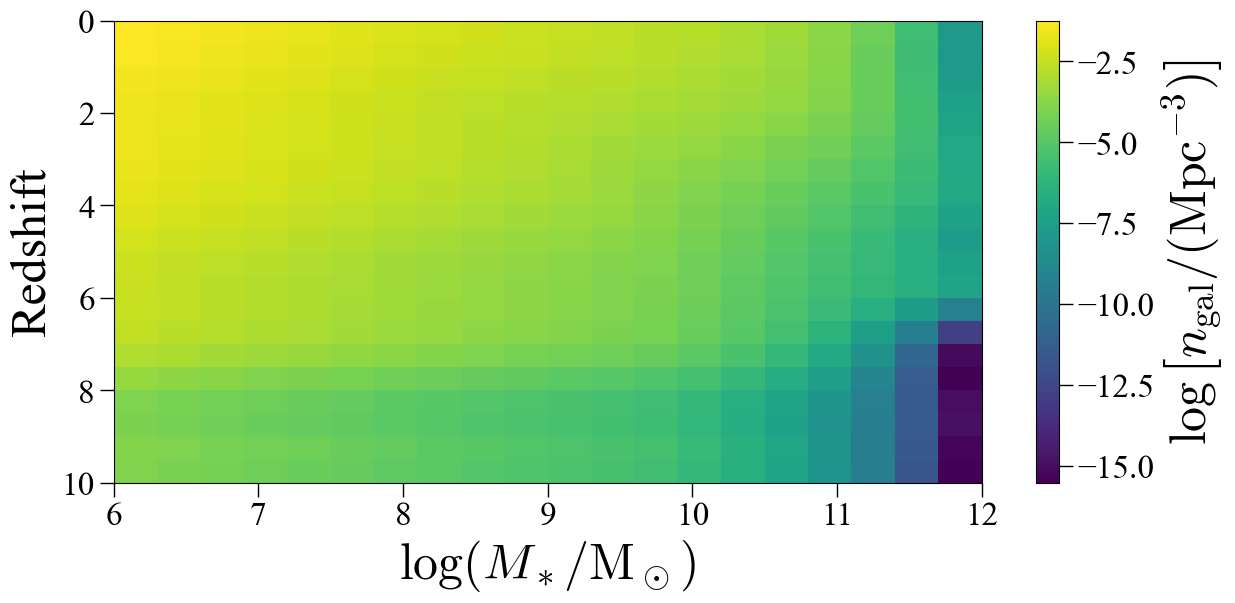

In [270]:
colormap = np.log10(np.sum(bg_ndensity, axis=2))

fig, ax = plt.subplots(figsize=(14,6))
vmin = np.nanmin(colormap)
vmax = np.nanmax(colormap)

ax.pcolormesh(bg_logms, bg_redshifts, colormap, vmin=vmin, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Redshift')
ax.set_xlabel(r'$\log(M_\ast/\mathrm{M}_\odot)$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\log\left[n_\mathrm{gal}/(\mathrm{Mpc}^{-3})\right]$')

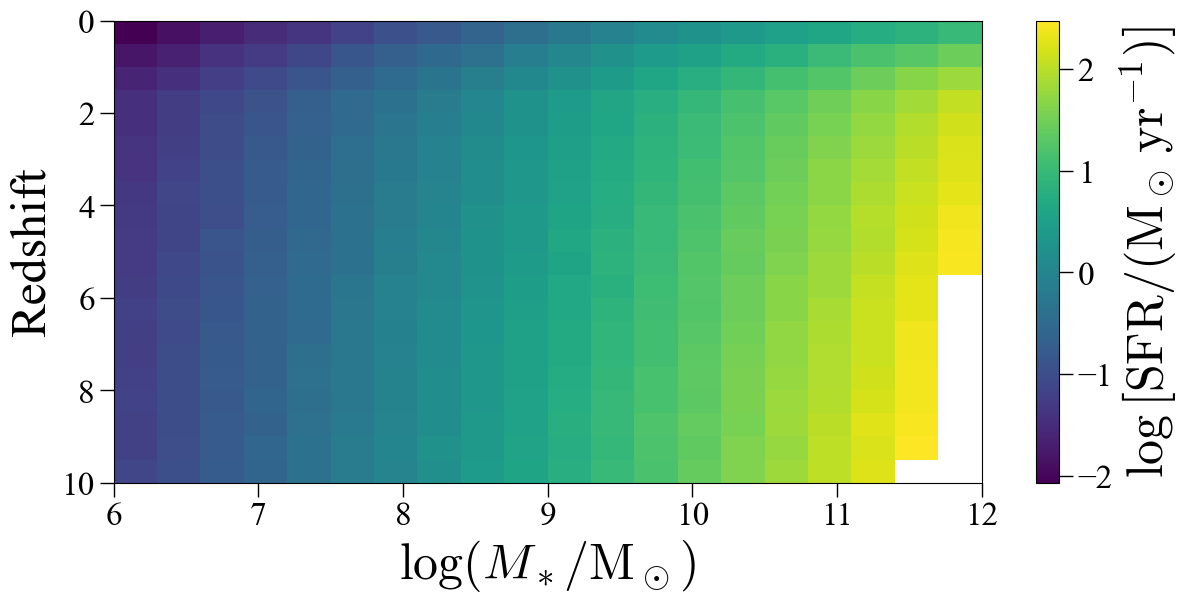

In [271]:
colormap = np.log10(np.mean(bg_sfr, axis=2))

fig, ax = plt.subplots(figsize=(14,6))
vmin = np.nanmin(colormap)
vmax = np.nanmax(colormap)

ax.pcolormesh(bg_logms, bg_redshifts, colormap, vmin=vmin, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Redshift')
ax.set_xlabel(r'$\log(M_\ast/\mathrm{M}_\odot)$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')

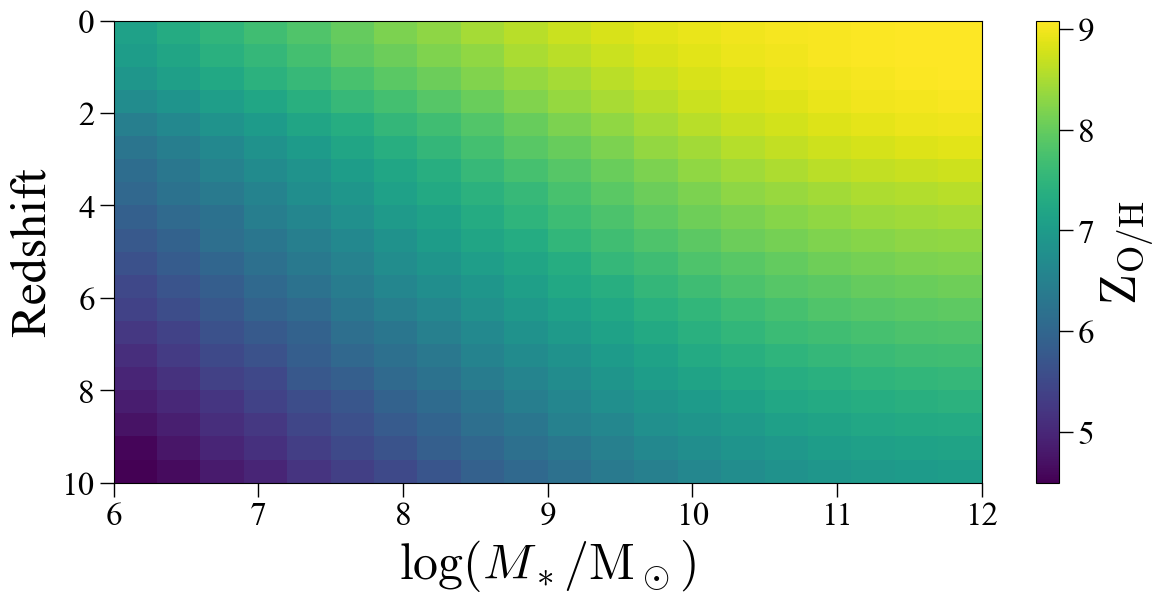

In [272]:
colormap = np.mean(bg_zoh, axis=2)

fig, ax = plt.subplots(figsize=(14,6))
vmin = np.nanmin(colormap)
vmax = np.nanmax(colormap)

ax.pcolormesh(bg_logms, bg_redshifts, colormap, vmin=vmin, vmax=vmax)
ax.invert_yaxis()
ax.set_ylabel('Redshift')
ax.set_xlabel(r'$\log(M_\ast/\mathrm{M}_\odot)$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\mathrm{Z}_\mathrm{O/H}$')

We want the SFRD grid over metallicity adn SFR. First, re-organize the sample.

In [273]:
bg_redshift = np.tile(bg_redshifts.reshape((side,1)), (1, side)).reshape((side, side, 1))
bg_redshift = np.tile(bg_redshift, (1, 1, bin_sample_size))

In [274]:
bg_logm = np.tile(bg_logms, (side, 1)).reshape((side, side, 1))
bg_logm = np.tile(bg_logm, (1, 1, bin_sample_size))

In [275]:
bg_sample = np.array([bg_redshift, 
                      bg_logm,
                      bg_ndensity, 
                      np.log10(bg_sfr), 
                      bg_zoh])

In [276]:
bg_sample = bg_sample.T.reshape((side*side*bin_sample_size, 5))

So that each line is a "galaxy" with `(redshift, logm, ndensity, log(sfr), zoh)`. Now defined the bins, sum the densities and multiply by the corresponding SFR.

In [277]:
bg_min_logsfr = np.nanmin(bg_sample[:, 3])
bg_max_logsfr = np.nanmax(bg_sample[:, 3])
bg_min_zoh = np.nanmin(bg_sample[:, 4])
bg_max_zoh = np.nanmax(bg_sample[:, 4])

bg_logsfr_grid = np.linspace(bg_min_logsfr, bg_max_logsfr, side+1)
bg_zoh_grid = np.linspace(bg_min_zoh, bg_max_zoh, side+1)
bg_logsfrd_grid = np.zeros((side, side))

for row, (zoh0, zoh1) in enumerate(zip(bg_zoh_grid[:-1], bg_zoh_grid[1:])):
    zoh_sample = bg_sample[np.logical_and(bg_sample[:, 4] >= zoh0, bg_sample[:, 4] < zoh1)]
    #print(zoh0, zoh1, zoh_sample.shape)
    for col, (logsfr0, logsfr1) in enumerate(zip(bg_logsfr_grid[:-1], bg_logsfr_grid[1:])):
        sfr_sample = zoh_sample[np.logical_and(zoh_sample[:, 3] >= logsfr0, zoh_sample[:, 3] < logsfr1)]
        sfr_sample = sfr_sample[~np.isnan(sfr_sample[:,3])]
        #print(logsfr0, logsfr1, sfr_sample.shape)
        sfrd = np.sum(sfr_sample[:,2] * 10.**sfr_sample[:,3])
        bg_logsfrd_grid[row, col] = np.log10(sfrd)

/tmp/ipykernel_102536/4086427889.py:18: RuntimeWarning: divide by zero encountered in log10
  bg_logsfrd_grid[row, col] = np.log10(sfrd)


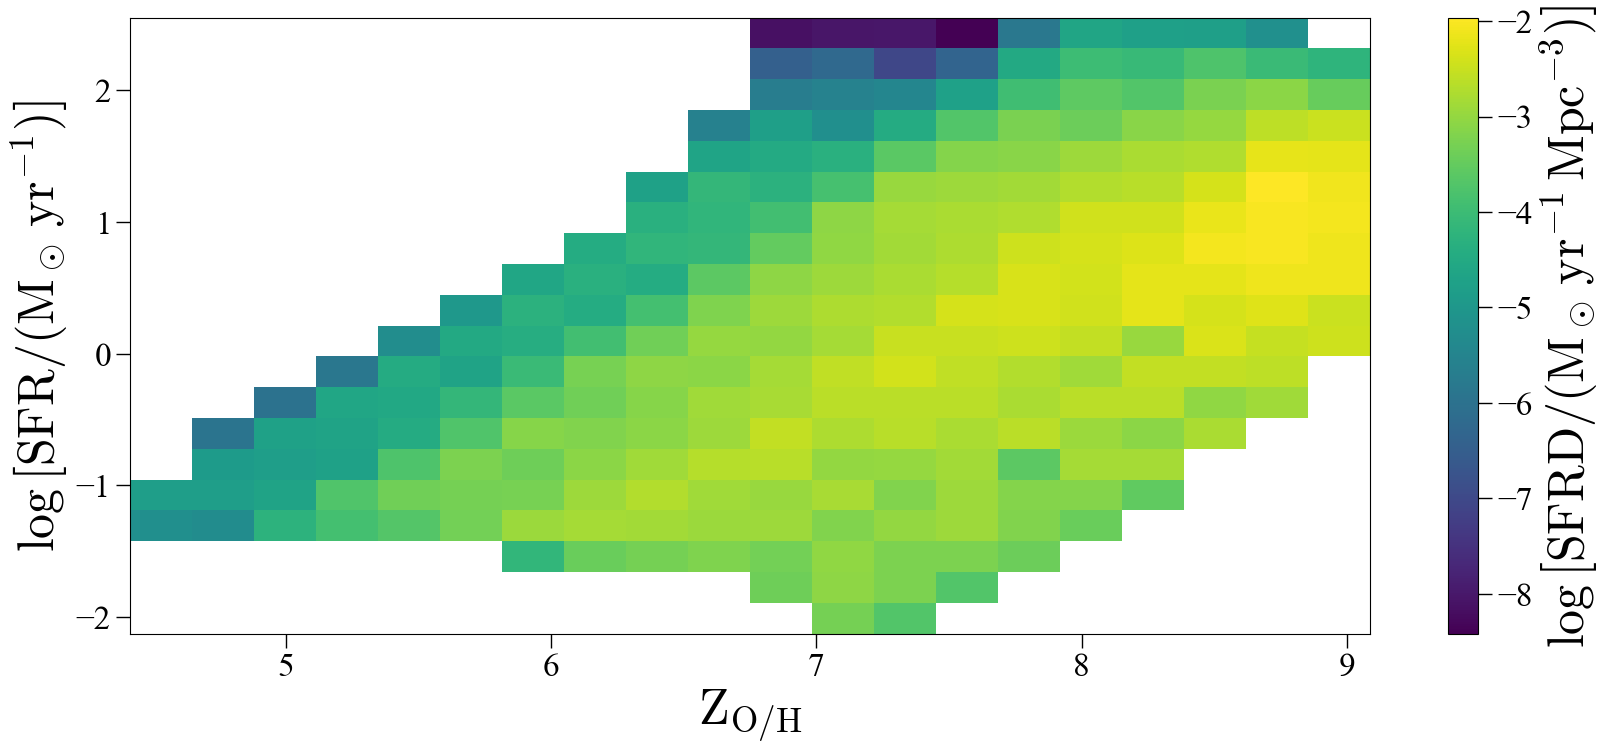

In [278]:
colormap = bg_logsfrd_grid.T
x = bg_zoh_grid
y = bg_logsfr_grid

fig, ax = plt.subplots(figsize=(20,8))
vmin = np.nanmin(colormap[colormap != -np.inf])
vmax = np.nanmax(colormap[colormap != np.inf])

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)
#ax.invert_yaxis()
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

All that is left to do is to decorate the plot with a few extra guidelines.

In [281]:
# Scatterless constant redshift curves
guideline_redshifts = np.arange(0, 12, 2)
guideline_logms = np.linspace(6, 12, 30)
redshift_guide_plot = np.zeros((guideline_redshifts.shape[0], 2, guideline_logms.shape[0]))
for i, z in enumerate(guideline_redshifts):
    for j, logm in enumerate(guideline_logms):
        redshift_guide_plot[i, 1, j], redshift_guide_plot[i, 0, j] = get_sample([logm], z, **model_settings)    
        redshift_guide_plot[i, 1, j] = np.log10(redshift_guide_plot[i, 1, j])

/tmp/ipykernel_102536/1336902378.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  redshift_guide_plot[i, 1, j], redshift_guide_plot[i, 0, j] = get_sample([logm], z, **model_settings)


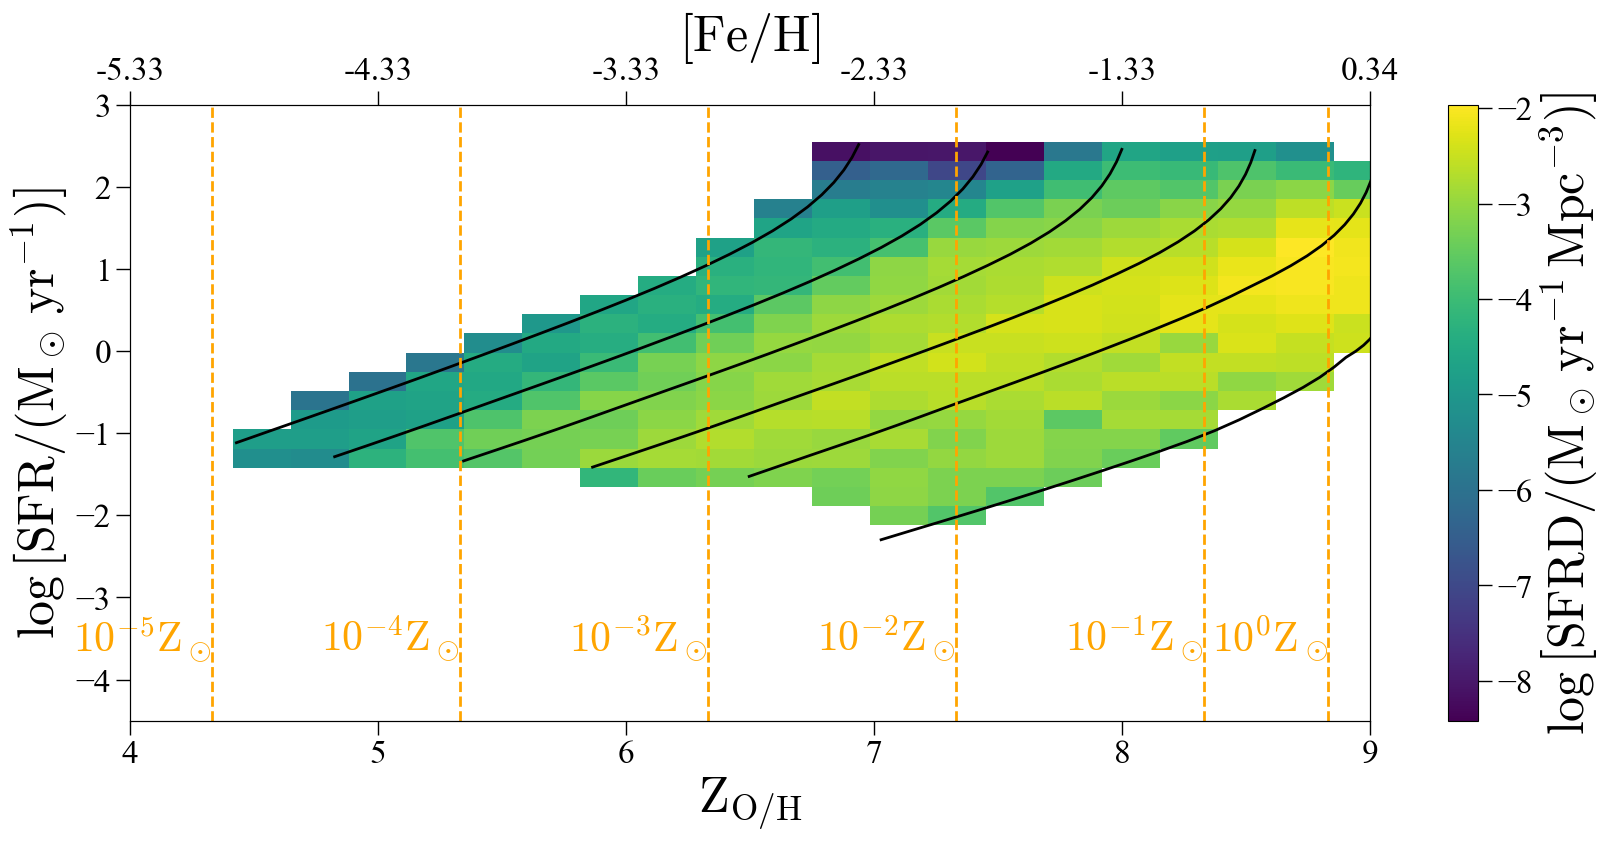

In [282]:
colormap = bg_logsfrd_grid.T
x = bg_zoh_grid
y = bg_logsfr_grid

minx = np.floor(x.min())
maxx = np.floor(x.max())
miny = np.floor(y.min())*1.5
maxy = np.floor(y.max())*1.5

fig, ax = plt.subplots(figsize=(20,8))
vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Scatterless constant redshift curves
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(ax.get_xticks())
feh_ax_labels = [ZOH_to_FeH(x) for x in ax.get_xticks()]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.floor(max(feh_ax_labels))+1, 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh, miny+1, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='center', ha='right', color='orange')


ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')

# Sample plot

In [283]:
n_redshift = 3
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_min = 6
logm_max = 12
logm_per_redshift = 3
mzr_model = MZR_option
sfmr_flattening = SFMR_option
gsmf_slope_fixed = GSMF_option
sampling_mode = 'sfr' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [284]:
bg_galaxygrid = GalaxyGrid(n_redshift,
                        redshift_min,
                        redshift_max,
                        force_boundary_redshift,
                        logm_per_redshift,
                        logm_min, 
                        logm_max, 
                        mzr_model, 
                        sfmr_flattening,
                        gsmf_slope_fixed,
                        sampling_mode,
                        scatter_model,
                        apply_igimf_corrections,
                        random_state)

In [285]:
%%time
bg_galaxygrid.sample_redshift()

CPU times: user 37.7 s, sys: 7.98 ms, total: 37.7 s
Wall time: 37.7 s


In [286]:
%%time
bg_galaxygrid.get_grid()

CPU times: user 596 ms, sys: 0 ns, total: 596 ms
Wall time: 595 ms


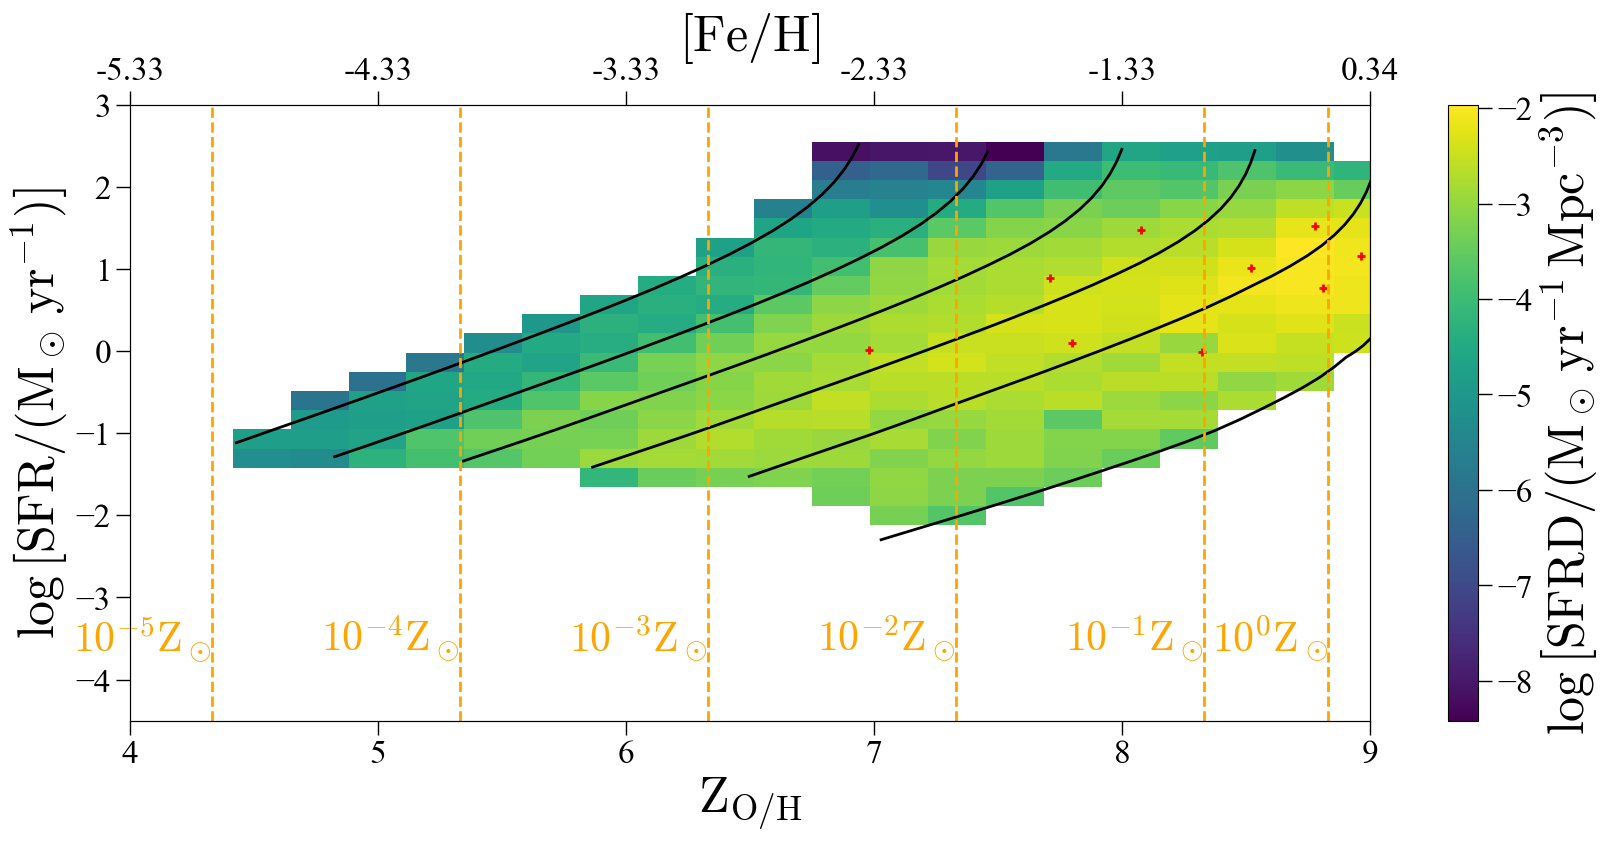

In [287]:
colormap = bg_logsfrd_grid.T
x = bg_zoh_grid
y = bg_logsfr_grid

grid = bg_galaxygrid

minx = np.floor(x.min())
maxx = np.floor(x.max())
miny = np.floor(y.min())*1.5
maxy = np.floor(y.max())*1.5

fig, ax = plt.subplots(figsize=(20,8))
vmin = colormap[colormap != -np.inf].min()
vmax = colormap[colormap != np.inf].max()

# Background
ax.pcolormesh(x, y, colormap, vmin=vmin, vmax=vmax)

# Sample
for z, zohs, sfrs in zip(grid.sample_redshift_array, grid.zoh_list, grid.sfr_list):
    ax.scatter(zohs, sfrs, color='r', marker='+')

# Scatterless constant redshift curves
for z, guide_plot in zip(guideline_redshifts, redshift_guide_plot):
    ax.plot(guide_plot[0], guide_plot[1], 'k-')

# SFR axis
ax.set_ylim(miny, maxy)

# Z_O/H axis
ax.set_xlim(minx, maxx)

# [Fe/H] axis
feh_ax = ax.twiny()
feh_ax.set_xlim(ax.get_xlim())
feh_ax.set_xticks(ax.get_xticks())
feh_ax_labels = [ZOH_to_FeH(x) for x in ax.get_xticks()]
feh_ax.set_xticklabels([f'{x:.2f}' for x in feh_ax_labels])

# Z guidelines
z_guidelines_fehs = np.arange(np.ceil(min(feh_ax_labels)), np.floor(max(feh_ax_labels))+1, 1)
z_guidelines_zohs = np.array([ZOH_from_FeH(x) for x in z_guidelines_fehs])
for feh, zoh in zip(z_guidelines_fehs, z_guidelines_zohs):
    ax.vlines(zoh, miny, maxy, color='orange', linestyle='--')
    ax.text(zoh, miny+1, f'$10^{{{feh:.0f}}}\\mathrm{{Z}}_\\odot$', va='center', ha='right', color='orange')

# Labels
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_xlabel(r'$\mathrm{Z}_\mathrm{O/H}$')
feh_ax.set_xlabel(r'$\mathrm{[Fe/H]}$')
fig.colorbar(mappable=cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='viridis'), 
             ax=ax, 
             label=r'$\log\left[\mathrm{SFRD}/(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{Mpc}^{-3})\right]$')